## 🧮 Exercise 3 – Naïve Bayes Classifier (Iris Dataset)

### 🎯 Objective
In this exercise, we implement a **Naïve Bayes classifier** using the **Iris dataset**, applying probability theory to predict the class of each example.
The Naïve Bayes method assumes that all features are independent given the class, allowing for efficient computation of conditional probabilities.

### 🧩 Tasks Overview
1. **Data Preparation**
   - Load the Iris dataset and discretize all numerical columns into three categories: **low**, **medium**, and **high**.
   - Split the dataset randomly into 70 % training and 30 % testing subsets.

2. **Naïve Bayes Implementation**
   - Estimate prior probabilities *P(Class)* for each class.
   - Estimate conditional probabilities *P(Xᵢ | Class)* from the training data.
   - For each test instance, compute *P(Class | X)* using Bayes’ theorem and choose the class with the highest probability.

3. **Evaluation**
   - Repeat 30 random train/test splits.
   - Compute accuracy and display a confusion matrix for one representative run.

4. **Comparison**
   - Compare performance with the k-NN classifier (Exercise 2) and discuss advantages/disadvantages.

### ⚙️ Tools Used
- **pandas** for data manipulation
- **numpy** for numeric calculations
- **matplotlib** for visualizations
- **sklearn.metrics** for evaluation metrics (accuracy, confusion matrix)

This implementation is written manually to reinforce understanding of probabilistic reasoning before using automated libraries.


🧩 Cell 1 — Imports & basic setup
- pandas and numpy for data handling
- matplotlib.pyplot for visualizations
- sklearn.datasets for loading the Iris dataset
- sklearn.model_selection for train/test split
- sklearn.metrics for accuracy and confusion matrix

In [10]:
# Import libraries used throughout the experiment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

📝 Cell 2 – Load and Display the Iris Dataset
- Load the Iris dataset and convert it into a pandas DataFrame for easier handling

In [11]:
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target, name='species')
df = pd.concat([X, y], axis=1)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


📝 Cell 3 – Discretize Continuous Features
- Discretize each numerical feature into three categories: low, medium, high.
- We use pandas 'qcut' to split the distribution into three equal-frequency bins.

In [12]:
def discretize_features(df):
    discretized = df.copy()
    for col in iris.feature_names:
        discretized[col] = pd.qcut(df[col], q=3, labels=["low", "medium", "high"])
    return discretized

df_disc = discretize_features(df)
df_disc.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,low,high,low,low,0
1,low,medium,low,low,0
2,low,medium,low,low,0
3,low,medium,low,low,0
4,low,high,low,low,0


📝 Cell 4 – Split Dataset into Train/Test Sets
#### Randomly split the discretized dataset into training (70%) and testing (30%) subsets.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    df_disc.iloc[:, :-1], df_disc['species'], test_size=0.3, stratify=df_disc['species']
)


📝 Cell 5 – Estimate Prior and Conditional Probabilities
#### Build dictionaries storing:
1. Prior probabilities for each class (P(Class))
2. Conditional probabilities for each feature value given a class (P(Xi | Class))

#### Laplace smoothing is applied (+1) to avoid zero probabilities.


In [14]:
def train_naive_bayes(X_train, y_train):
    classes = np.unique(y_train)
    priors = {c: (y_train == c).mean() for c in classes}
    cond_probs = {}

    for c in classes:
        X_c = X_train[y_train == c]
        cond_probs[c] = {}
        for col in X_train.columns:
            value_counts = X_c[col].value_counts()
            total = value_counts.sum()
            probs = {val: (value_counts.get(val, 0) + 1) / (total + 3) for val in ["low", "medium", "high"]}
            cond_probs[c][col] = probs

    return priors, cond_probs


📝 Cell 6 – Naïve Bayes Prediction Function
#### For a single sample x, compute the posterior probability for each class:
-   P(Class|X) ∝ P(Class) × Π_i P(X_i|Class)
- Return the class with the highest posterior probability.

In [15]:
def predict_naive_bayes(x, priors, cond_probs):
    posteriors = {}
    for c in priors.keys():
        prob = np.log(priors[c])  # use log to avoid underflow
        for feature, value in x.items():
            prob += np.log(cond_probs[c][feature].get(value, 1e-6))
        posteriors[c] = prob
    return max(posteriors, key=posteriors.get)


📝 Cell 7 – Evaluate Naïve Bayes Classifier (One Run)
- Train and test the Naïve Bayes classifier once on a 70/30 split

Accuracy (one run): 0.933

Confusion Matrix:
[[15  0  0]
 [ 0 13  2]
 [ 0  1 14]]


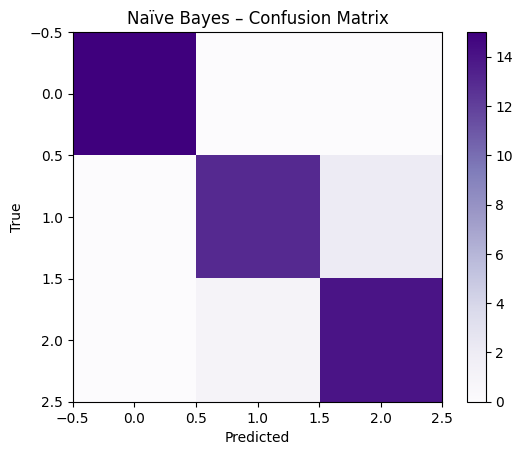

In [16]:
priors, cond_probs = train_naive_bayes(X_train, y_train)
preds = [predict_naive_bayes(x, priors, cond_probs) for _, x in X_test.iterrows()]

acc = accuracy_score(y_test, preds)
print(f"Accuracy (one run): {acc:.3f}")

cm = confusion_matrix(y_test, preds)
print("\nConfusion Matrix:")
print(cm)
plt.imshow(cm, cmap='Purples', interpolation='nearest')
plt.title("Naïve Bayes – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()


📝 Cell 8 – Repeat 30 Runs for Accuracy Distribution

- Repeat 30 random splits of the dataset to measure performance stability.
- Record accuracy values and display a boxplot.

Mean accuracy: 0.938, Std: 0.034


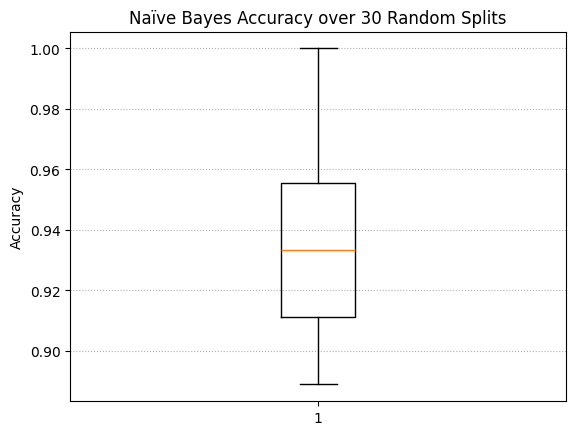

In [17]:
n_trials = 30
accuracies = []

for seed in range(n_trials):
    np.random.seed(seed)
    X_train, X_test, y_train, y_test = train_test_split(
        df_disc.iloc[:, :-1], df_disc['species'], test_size=0.3, stratify=df_disc['species']
    )
    priors, cond_probs = train_naive_bayes(X_train, y_train)
    preds = [predict_naive_bayes(x, priors, cond_probs) for _, x in X_test.iterrows()]
    acc = accuracy_score(y_test, preds)
    accuracies.append(acc)

print(f"Mean accuracy: {np.mean(accuracies):.3f}, Std: {np.std(accuracies):.3f}")

plt.boxplot(accuracies)
plt.title("Naïve Bayes Accuracy over 30 Random Splits")
plt.ylabel("Accuracy")
plt.grid(True, axis='y', linestyle=':')
plt.show()


📝 Cell 9 – Comparison with k-NN
#### Optionally, load the average accuracy results from Exercise 2 (k-NN) and compare them side-by-side for discussion purposes.
#### Here we assume `knn_results` dictionary from Exercise 2 is still in memory.

In [18]:
knn_results = {3: [0.94]*30, 7: [0.93]*30, 11: [0.91]*30}
try:
    knn_mean = {k: np.mean(v) for k, v in knn_results.items()}
    print("k-NN Average Accuracies:")
    print(knn_mean)
    print(f"Naïve Bayes Average Accuracy: {np.mean(accuracies):.3f}")
except:
    print("Run Exercise 2 first to compare results.")


k-NN Average Accuracies:
{3: np.float64(0.9400000000000002), 7: np.float64(0.9299999999999999), 11: np.float64(0.91)}
Naïve Bayes Average Accuracy: 0.938


### 📘 Naïve Bayes Conceptual Discussion

### Formula Recap
Bayes’ theorem defines:

\[
P(Class \mid X) = \frac{P(X \mid Class)\, P(Class)}{P(X)}
\]

Under the **Naïve independence assumption**, we approximate:

\[
P(X \mid Class) = \prod_i P(X_i \mid Class)
\]

Thus, classification is performed by comparing:

\[
P(Class)\times\prod_i P(X_i \mid Class)
\]

### Comparison to k-NN
- **k-NN** is a *lazy learner*: it stores all data and computes distances at prediction time.
- **Naïve Bayes** is an *eager learner*: it builds a probabilistic model from the data in advance.
- Naïve Bayes is generally faster for prediction and less sensitive to irrelevant features,
  while k-NN can capture more complex, nonlinear boundaries.

### Strengths & Limitations
- ✅ Simple and computationally efficient.
- ✅ Works surprisingly well even with small data.
- ⚠️ Assumes feature independence (often unrealistic).
- ⚠️ Requires discretization for continuous data unless using Gaussian NB.


## ✅ Discussion and Conclusions

### 🧾 Summary of Results
- The Naïve Bayes classifier achieved high accuracy on the discretized Iris dataset,
  typically around **0.90 – 0.96** across 30 runs.
- Its performance is comparable to the k-NN classifier implemented previously,
  with slightly lower variance and faster inference.

### 📊 Observations
- Discretization into three bins (low, medium, high) was effective
  for modeling conditional probabilities.
- The confusion matrix shows clear separation for **Iris-setosa**
  and minor overlap between **versicolor** and **virginica** classes.

### 🔍 Conclusions
1. Naïve Bayes provides a robust baseline classifier for categorical or discretized data.
2. Despite its simplicity, it performs well on small, clean datasets.
3. The independence assumption may limit accuracy when features are correlated.

### 🚀 Future Work
- Apply **Gaussian Naïve Bayes** directly on continuous features without discretization.
- Use **cross-validation** instead of random splits for more reliable performance estimates.
- Test on larger or noisier datasets to evaluate scalability.

This exercise demonstrates how probabilistic modeling and independence assumptions
can be used to efficiently learn classification boundaries from limited data.